# 3. Ley de gravitación universal con más entradas derivadas

En este cuadernillo repetiremos el experimento de **00_grav_law**, pero añadiendo más entradas a la red neuronal. Las entradas que añadimos están relacionadas con las variables de entrada de la función que estamos aproximando. El objetivo es ver cómo se comporta el modelo.

Repetimos los mismo pasos que en el cuadernillo anterior. Solo se destacan los cambios más relevantes.

A continuación, definimos las funciones para crear los conjuntos de datos.

In [13]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Genera una muestra de n observaciones de la variable aleatoria X
def dataset_point(n, r_min=1.295, r_max=5.0):
    u = torch.rand(n)
    r_cubed = u * (r_max**3 - r_min**3) + r_min**3
    r = r_cubed**(1/3)

    u_theta = torch.rand(n)
    u_phi = torch.rand(n)
    theta = torch.acos(1 - 2 * u_theta)
    phi = 2 * torch.pi * u_phi

    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Genera una muestra de n observaciones de la variable aleatoria D
def dataset_distance(n, r_min=1.3, r_max=5.0):
    points = dataset_point(2*n, r_min, r_max)
    p1 = points[:n]
    p2 = points[n:]
    return torch.norm(p1 - p2, dim=1)

# Genera una muestra de n observaciones de la variable aleatoria M
def dataset_mass(n, m_min=0.5, m_max=5.0, alpha=2.3):
    inv = 1.0 - alpha
    lower = m_min**inv
    upper = m_max**inv

    u = torch.rand(n)
    m = (lower + u*(upper - lower))**(1.0/inv)
    return m

La siguiente función genera el conjunto de datos con una variable adicional que es la raíz cuadrada de la variable $d$.

In [15]:
def create_dataset_extra_input(train_num=10000, test_num=5000):

    # Esta función genera un conjunto de datos (x,y) con una cantidad de datos menor a num (porque algunos se filtran)
    def generate_grav(num):
        # Generamos las distancias y filtramos
        d = dataset_distance(num, 1.295, 5)
        d = d[d > 1]

        # Generamos las masas una vez hemos filtrado
        new_num = len(d)
        m1 = dataset_mass(new_num)
        m2 = dataset_mass(new_num)

        # Calculamos el valor de F
        G = 2.773
        F = G*(m1*m2)/(d**2)

        # Añadimos variable relacionada con d
        x1 = d**(1/2)

        x = torch.stack([m1, m2, d, x1], dim=1)
        y = F.unsqueeze(dim=1)

        # Filtramos las valores de F muy pequeños
        mask = (y.squeeze() > 0.1)
        x = x[mask]
        y = y[mask]

        return x,y

    x_train, y_train = generate_grav(train_num)
    x_test, y_test = generate_grav(test_num)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

In [16]:
# Iniciamos la KAN
model = KAN(width=[4,5,1], grid=3, k=3, seed=2025, device=device);

dataset = create_dataset_extra_input()

checkpoint directory created: ./model
saving model version 0.0


In [17]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.03);

| train_loss: 1.79e-01 | test_loss: 1.85e-01 | reg: 8.12e+00 | : 100%|█| 100/100 [00:25<00:00,  3.92

saving model version 0.1


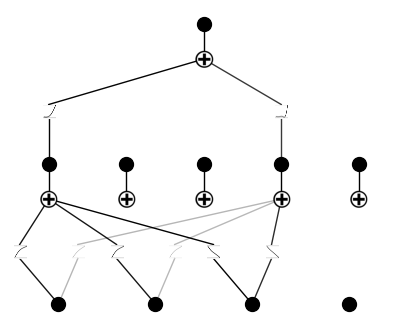

In [18]:
# Visualizamos la red
model.plot()

In [19]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


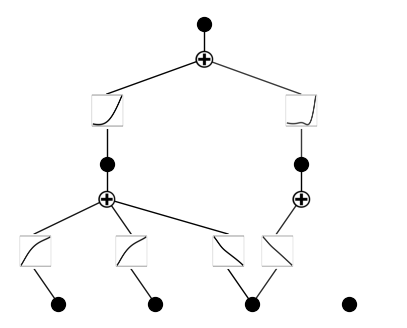

In [20]:
# Mostramos el modelo podado
pruned_model.plot()

In [21]:
# Volvemos a entrenar el modelo con regularización
pruned_model.fit(dataset, opt="LBFGS", steps=100, lamb=0.03);

| train_loss: 6.46e-02 | test_loss: 7.04e-02 | reg: 5.53e+00 | : 100%|█| 100/100 [00:18<00:00,  5.48

saving model version 0.3


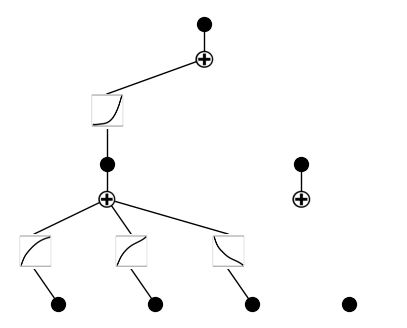

In [22]:
pruned_model.plot()

In [23]:
# Podamos la red
pruned_model = pruned_model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.4


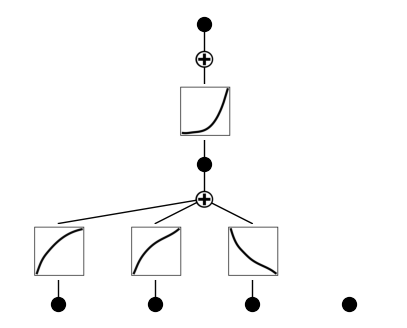

In [24]:
pruned_model.plot()

In [25]:
# Volvemos a entrenar el modelo tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.28e-02 | test_loss: 1.46e-02 | reg: 8.43e+00 | : 100%|█| 100/100 [00:17<00:00,  5.65

saving model version 0.5


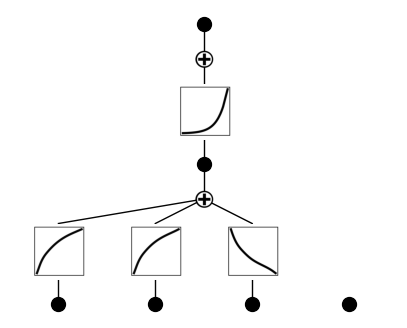

In [26]:
pruned_model.plot()

In [27]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999728 -11.791835           2                2   -0.758367
1    1/x^0.5    0.999524 -11.005510           2                2   -0.601102
2  1/sqrt(x)    0.999524 -11.005510           2                2   -0.601102
3        1/x    0.999167 -10.211917           2                2   -0.442383
4      1/x^2    0.998648  -9.519855           2                2   -0.303971
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999694 -11.629647           2                2   -0.725929
1    1/x^0.5    0.999671 -11.524324           2                2   -0.704865
2  1/sqrt(x)    0.999671 -11.524324           2                2   -0.704865
3        1/x    0.999409 -10.699823           2                2   -0.539965
4      1/x^2    0.998990  -9.937551           2                2   -0.387510
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Podemos utilizar un razonamiento similar al del otro cuardernillo para elegir $\log$ en la primera capa y $\exp$ en la segunda.

In [28]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.9997279644012451
saving model version 0.6
r2 is 0.9996944069862366
saving model version 0.7
r2 is 0.9997525811195374
saving model version 0.8
r2 is 0.9999603033065796
saving model version 0.9


Volvemso a entrenar el modelo y vemos el resultado.

In [29]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 5.67e-07 | test_loss: 6.40e-07 | reg: 0.00e+00 | : 100%|█| 100/100 [00:09<00:00, 10.78

saving model version 0.10


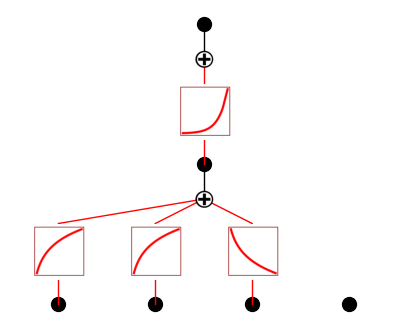

In [30]:
pruned_model.plot()

Como podemos ver, obtenemos una aproximación bastante buena de la función objetivo.

In [31]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.773*x_1**1.0*x_2**1.0/x_3**2.0